## EDA

We will perform EDA on the dataset of SQL injection available on Kaggle: [dataset_link](https://www.kaggle.com/sajid576/sql-injection-dataset)

In [1]:
import numpy as np
import pandas as pd

# Read the CSV file using ISO-8859-1 encoding
raw_dataset = pd.read_excel('Modified_SQL_Dataset.xlsx')

# Display information about the dataset
raw_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30911 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


There are no null/missing values in the dataset.  
We have two columns:
1. **Query**: SQL query
2. **Label**: 1 if injection 0 otherwise

In [2]:
raw_dataset.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [3]:
raw_dataset.tail()

,Query,Label
30914,DELETE FROM door WHERE grow = 'small',0
30915,DELETE FROM tomorrow,0
30916,SELECT wide ( s ) FROM west,0
30917,SELECT * FROM ( SELECT slide FROM breath ),0
30918,SELECT TOP 3 * FROM race,0


In [4]:
raw_dataset.isnull().sum()

Query    8
Label    0
dtype: int64

In [5]:
raw_dataset.isna().sum()

Query    8
Label    0
dtype: int64

<Axes: xlabel='Label'>

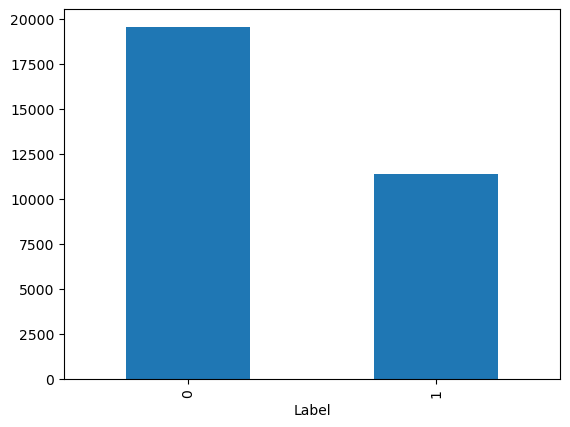

In [6]:
raw_dataset['Label'].value_counts().plot(kind='bar')

**Positive class** - 11382  
**Negative class** - 19537  
Dataset is imbalanced with popsitive to negative class ratio of 37:63 (~ 4:7)

### Duplicate removal

In [7]:
raw_dataset[raw_dataset.duplicated(keep=False)].sort_values(by=['Query'])

,Query,Label
19328,0.26,1
19322,0.26,1
19333,0.28,1
19319,0.28,1
19320,0.29,1
...,...,...
13532,NaN,0
15635,NaN,0
17913,NaN,0
18233,NaN,0


* Here we have found 20 duplicate values.
* All values looks like number and not like SQL query.
* Let us remove all the datapoints.

In [8]:
raw_dataset.drop_duplicates(keep=False, inplace=True)

In [9]:
raw_dataset.shape

(30632, 2)

## Data Cleaning

We have so many white spaces in the queries and multiple special characters.  
We can try to train model by removing the special characters.  
If this does not work, we can include special characters afterwards.  
Let's create two datasets one with and other without special characters.  
This all are SQL queries so no need to remove stop words.

In [10]:
import re

In [11]:
sample_query = raw_dataset['Query'][9780]
sample_query

"1'||  (  select 'rjis' from dual where 7696  =  7696 and 3754  =    (  select upper  (  xmltype  (  chr  (  60  )  ||chr  (  58  )  ||chr  (  113  )  ||chr  (  113  )  ||chr  (  112  )  ||chr  (  106  )  ||chr  (  113  )  ||  (  select   (  case when   (  3754  =  3754  )   then 1 else 0 end  )   from dual  )  ||chr  (  113  )  ||chr  (  122  )  ||chr  (  118  )  ||chr  (  122  )  ||chr  (  113  )  ||chr  (  62   )    )     )   from dual   )    )   ||'"

In [12]:
def remove_spaces(input_string):
    cleaned = re.sub('\s{2,}',' ',input_string)
    return cleaned.lower().strip()

print(remove_spaces(sample_query))

1'|| ( select 'rjis' from dual where 7696 = 7696 and 3754 = ( select upper ( xmltype ( chr ( 60 ) ||chr ( 58 ) ||chr ( 113 ) ||chr ( 113 ) ||chr ( 112 ) ||chr ( 106 ) ||chr ( 113 ) || ( select ( case when ( 3754 = 3754 ) then 1 else 0 end ) from dual ) ||chr ( 113 ) ||chr ( 122 ) ||chr ( 118 ) ||chr ( 122 ) ||chr ( 113 ) ||chr ( 62 ) ) ) from dual ) ) ||'


In [13]:
def clean_all(input_string):
    cleaned = re.sub('[^a-zA-Z0-9\s]',' ',input_string)
    cleaned = re.sub('\s{2,}',' ',cleaned)
    return cleaned.lower().strip()
print(clean_all(sample_query))

1 select rjis from dual where 7696 7696 and 3754 select upper xmltype chr 60 chr 58 chr 113 chr 113 chr 112 chr 106 chr 113 select case when 3754 3754 then 1 else 0 end from dual chr 113 chr 122 chr 118 chr 122 chr 113 chr 62 from dual


In [14]:
dataset_with_special_characters = raw_dataset.copy()
dataset_with_special_characters['Query'] = dataset_with_special_characters['Query'].apply(remove_spaces)
dataset_with_special_characters.head()

TypeError: expected string or bytes-like object, got 'int'

In [ ]:
dataset_all_cleaned = raw_dataset.copy()
dataset_all_cleaned['Query'] = dataset_all_cleaned['Query'].apply(clean_all)
dataset_all_cleaned.head()

Let us see if we have any duplicates after removing special characters.

In [ ]:
dataset_all_cleaned[dataset_all_cleaned.duplicated(keep=False)].sort_values(by='Query')

In [ ]:
dataset_all_cleaned.drop_duplicates(keep='first', inplace=True)
dataset_all_cleaned.shape

**Special Characters Count**  
Let's find out if number of special characters in the query has any relation with dependent variable.

In [ ]:
no_of_special_chars = raw_dataset['Query'].map(lambda x:len(re.findall('[^a-zA-Z0-9\s]',x)))
no_of_special_chars.describe()

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
fig3, ax_sc = plt.subplots(1, 1, figsize=(15,8))
sns.histplot(no_of_special_chars[raw_dataset['Label']==1], ax=ax_sc, color='red', label='Malicious', binrange=(0,100) ,alpha=0.4)
sns.histplot(no_of_special_chars[raw_dataset['Label']==0], ax=ax_sc, color='green', label='Nomral', binrange=(0,100))
ax_sc.set_title("Special Character Distribution")
ax_sc.legend()

**NOTE**: Here we can see, Number of special characters in a query has almost sane distribution for normal and malicious queries. This is not a good feature to make classification.

Let's remove the duplicates and keep the first instance only.

In [ ]:
query_length = dataset_all_cleaned.Query.map(lambda x:len(x.split()))
query_length.describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
sns.histplot(query_length, binrange=(0,50), ax=ax1)
sns.histplot(query_length, binrange=(50,75), ax=ax2)
sns.histplot(query_length, binrange=(75,100), ax=ax3)
sns.histplot(query_length, binrange=(100,600), ax=ax4)
plt.suptitle("Query Length Distribution");

In [ ]:
print("0 words   =", (query_length==0).value_counts()[True])
print("1 words   =", (query_length==1).value_counts()[True])
print("2 words   =", (query_length==2).value_counts()[True])
print("Less than 5 words   =", (query_length<5).value_counts()[True])
print("Less than 10 words  =", (query_length<10).value_counts()[True])
print("Less than 15 words  =", (query_length<15).value_counts()[True])
print("Less than 50 words  =", (query_length<50).value_counts()[True])
print("More than 90 words =", (query_length>90).value_counts()[True])
print("More than 500 words =", (query_length>500).value_counts()[True])

Here we have one outlier where we do not have any query.
We need to find that and remove from dataset.

In [ ]:
for per in range(10,101,10):
    print(f'{per} percentile for query length = {np.percentile(query_length, per)}')
print('-'*40)
for per in range(91,101,1):
    print(f'{per} percentile for query length = {np.percentile(query_length, per)}')
print('-'*40)
for per in np.linspace(99,100,11):
    print(f'{per} percentile for query length = {np.percentile(query_length, per)}')

**Observations**  
From histogram, percentiles and other observations for query length:
1. 90% of the queries are having 19 or less words.
2. 95% of the queries are having 26 or less words.
3. Less than 1% of the data have more than 43 words.
4. Only one outlier query has 542 words.
5. Only one outlier query has 0 words (only space).

**Outlier Removal**  
Let's remove query with length 0(minimum) and 542(maximum).

In [ ]:
dataset_all_cleaned[dataset_all_cleaned['Query'].map(lambda x:len(x.split()))==0]

In [ ]:
dataset_all_cleaned[dataset_all_cleaned['Query'].map(lambda x:len(x.split()))==542]

In [ ]:
# with pd.option_context('display.max_colwidth', None):
long_query=dataset_all_cleaned[dataset_all_cleaned['Query'].map(lambda x:len(x.split()))==542]['Query'].item()
print(long_query)

**Above two data points are surely noisy and we can remove them.**

In [ ]:
dataset_all_cleaned.drop([208,19341], inplace=True)
dataset_all_cleaned.shape

Now let us check query length distribution for both classes.

In [ ]:
normal_queries = dataset_all_cleaned[dataset_all_cleaned['Label']==0]
malicious_queries = dataset_all_cleaned[dataset_all_cleaned['Label']==1]

In [ ]:
normal_queries_length = normal_queries.Query.map(lambda x:len(x.split()))
malicious_queries_length = malicious_queries.Query.map(lambda x:len(x.split()))

In [ ]:
fig2, ((ax21, ax22)) = plt.subplots(1, 2, figsize=(15,6))
sns.histplot(normal_queries_length, binrange=(0,50), ax=ax21, color='green', label='Nomral')
sns.histplot(normal_queries_length, binrange=(50,150), ax=ax22, color='green', label='Nomral')
sns.histplot(malicious_queries_length, binrange=(0,50), ax=ax21, color='red', label='Malicious', alpha=0.4)
sns.histplot(malicious_queries_length, binrange=(50,150), ax=ax22, color='red', label='Malicious', alpha=0.4)
ax21.set_title("Normal vs Malicious Queries")
ax22.set_title("Normal vs Malicious Queries")
ax21.legend()
ax22.legend();

**NOTE**: Query length for both classes are having almost same distribution so it won't add any value classifying dependent variable.

### Baseline model and feature selection  
Here our goal is to find out the words or series of words which are common in attacks.  
We can either use TFIDF or simple tokenization which will find out the pattern in n-gram features to identify the attack.  
**NOTE**: We will first try with all cleaned data.

In [ ]:
import pickle

In [ ]:
with open('dataset_all_cleaned.df', 'wb') as file:
  pickle.dump(dataset_all_cleaned, file)

In [ ]:
X = dataset_all_cleaned['Query']
y = dataset_all_cleaned['Label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

### Tokenization
We will tokenize data using counter vectorizer and TFIDF both.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=2500)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=2500)
X_train_tfidfvec = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidfvec = tfidf_vectorizer.transform(X_test)

Let us try to visualize data in 2D using TSNE

# from sklearn.manifold import TSNE
import time

# Reduce perplexity
perplexity_value = 5

# Start timing
start_time = time.time()

# Use init="random" instead of PCA initialization
tsne = TSNE(n_jobs=-1, perplexity=perplexity_value, init="random", method='barnes_hut', n_iter_without_progress=50)

# Fit and transform
embedded_data = tsne.fit_transform(X_train_vec, y_train)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time: {:.2f} seconds".format(execution_time))


# embedded_data.shape


# sns.scatterplot(x=embedded_data[:,0], y=embedded_data[:,1], hue=y_train, legend='full',)

# embedded_data = TSNE(perplexity=200).fit_transform(X_train_vec, y_train)
sns.scatterplot(x=embedded_data[:,0], y=embedded_data[:,1], hue=y_train, legend='full')

# embedded_data = TSNE(perplexity=300).fit_transform(X_train_vec, y_train)
sns.scatterplot(x=embedded_data[:,0], y=embedded_data[:,1], hue=y_train, legend='full')

# embedded_data = TSNE(perplexity=80).fit_transform(X_train_vec, y_train)
sns.scatterplot(x=embedded_data[:,0], y=embedded_data[:,1], hue=y_train, legend='full')

# embedded_data = TSNE(perplexity=50).fit_transform(X_train_vec, y_train)
sns.scatterplot(x=embedded_data[:,0], y=embedded_data[:,1], hue=y_train, legend='full')

# embedded_data = TSNE(perplexity=400, n_iter=3000).fit_transform(X_train_vec, y_train)
sns.scatterplot(x=embedded_data[:,0], y=embedded_data[:,1], hue=y_train, legend='full')

From TSNE result we can see that both classes are clearly separatable in 2D embedding of 2500 dimensional data.

### Random Forest Model
1. Using count vectorized data

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC_model = RandomForestClassifier()
RFC_model.fit(X_train_vec, y_train)
RFC_model.score(X_test_vec, y_test)

2. Using TFIDF vectorized data

In [ ]:
RFC_model_tfidf = RandomForestClassifier()
RFC_model_tfidf.fit(X_train_tfidfvec, y_train)
RFC_model_tfidf.score(X_test_tfidfvec, y_test)

In [ ]:
RFC_model_y_pred = RFC_model.predict(X_test_vec)
RFC_model_tfidf_y_pred = RFC_model_tfidf.predict(X_test_tfidfvec)

Confusion matrix

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print("F1 Score for simple model : ", round(f1_score(y_test, RFC_model_y_pred)*100,2),"%")
cm_1 = ConfusionMatrixDisplay(confusion_matrix(y_test, RFC_model_y_pred))
cm_1.plot()

In [ ]:
print("F1 Score for TFIDF model : ", round(f1_score(y_test, RFC_model_tfidf_y_pred)*100,2),"%")
cm_2 = ConfusionMatrixDisplay(confusion_matrix(y_test, RFC_model_tfidf_y_pred))
cm_2.plot()

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, RFC_model_y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display.plot()
print("roc_auc = ", round(roc_auc*100,2))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, RFC_model_tfidf_y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest (TFIDF)')
display.plot()
print("roc_auc = ", round(roc_auc*100,2))

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
cross_val_score(RFC_model, X_train_vec, y_train, cv=5, scoring='f1')

In [ ]:
cross_validate(RFC_model, X_train_vec, y_train, cv=3, scoring='f1', n_jobs=-1)

In [ ]:
importances = RFC_model.feature_importances_
forest_importances = pd.Series(importances, index=vectorizer.get_feature_names_out())
forest_importances.sort_values(inplace=True, ascending=False)
forest_importances[:50].plot(kind='bar', figsize=(16,4))

In [ ]:
cross_validate(RFC_model_tfidf, X_train_tfidfvec, y_train, cv=3, scoring='f1', n_jobs=-1)

In [ ]:
importances = RFC_model_tfidf.feature_importances_
forest_importances = pd.Series(importances, index=tfidf_vectorizer.get_feature_names_out())
forest_importances.sort_values(inplace=True, ascending=False)
forest_importances[:50].plot(kind='bar', figsize=(16,4))

#### Observations
1. We are getting really good accuracy and f1-score for both normal vectorizer and TFIDF vectorizer.  
2. We have currently used only words **without any special characters**.  
  
Let's try to train Random Forest model on the data **with special characters** for TFIDF vectorizer.

In [ ]:
dataset_with_special_characters.shape

In [ ]:
dataset_with_special_characters[dataset_with_special_characters.duplicated(keep='first')]

In [ ]:
dataset_with_special_characters.drop_duplicates(keep='first', inplace=True)

In [ ]:
X_schar = dataset_with_special_characters['Query']
y_schar = dataset_with_special_characters['Label']

In [ ]:
X_train_schar, X_test_schar, y_train_schar, y_test_schar = train_test_split(X_schar, y_schar, test_size=0.30, random_state=42)

In [ ]:
tfidf_vectorizer_schar = TfidfVectorizer(ngram_range=(1,3), max_features=2500)
X_train_tfidfvec_schar = tfidf_vectorizer_schar.fit_transform(X_train_schar)
X_test_tfidfvec_schar = tfidf_vectorizer_schar.transform(X_test_schar)

In [ ]:
RFC_model_tfidf_schar = RandomForestClassifier()
RFC_model_tfidf_schar.fit(X_train_tfidfvec_schar, y_train_schar)
RFC_model_tfidf_schar.score(X_test_tfidfvec_schar, y_test_schar)

In [ ]:
RFC_model_tfidf_y_pred_schar = RFC_model_tfidf_schar.predict(X_test_tfidfvec_schar)
print("F1 Score for simple model : ", round(f1_score(y_test_schar, RFC_model_tfidf_y_pred_schar)*100,2),"%")
cm_1 = ConfusionMatrixDisplay(confusion_matrix(y_test_schar, RFC_model_tfidf_y_pred_schar))
cm_1.plot()

**NOTE**: Here we can see that model is making more errors for type-1 while special characters are included.

In [ ]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(estimator=RFC_model_tfidf_schar,param_grid={'n_estimators': [10, 100, 500], 'oob_score': (True, False)}, n_jobs=-1, scoring='f1')

In [ ]:
clf.fit(X_train_tfidfvec_schar, y_train_schar)

In [ ]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by='rank_test_score')

In [ ]:

RFC_model_tfidf_schar_bestCV = clf.best_estimator_

In [ ]:
# RFC_model_tfidf_schar_bestCV.fit(X_train_tfidfvec_schar, y_train_schar)
RFC_model_tfidf_schar_bestCV.score(X_test_tfidfvec_schar, y_test_schar)

In [ ]:
RFC_model_tfidf_y_pred_schar = RFC_model_tfidf_schar_bestCV.predict(X_test_tfidfvec_schar)
print("F1 Score for simple model : ", round(f1_score(y_test_schar, RFC_model_tfidf_y_pred_schar)*100,2),"%")
cm_1 = ConfusionMatrixDisplay(confusion_matrix(y_test_schar, RFC_model_tfidf_y_pred_schar))
cm_1.plot()

Even After doing hyperparameter tuning, we are not getting better score with special characters.  

## Conclusion
1. We get better results by removing special characters.
2. We get almost same result for normal count vectorizer and TFIDF vectorizer.
3. Random Forest model with default parameters works the best.

In [ ]:
import pickle

In [ ]:
import pickle
filename='sql.sav'
pickle.dump(RFC_model ,open('sql.sav','wb'))
loaded_model=pickle.load(open('sql.sav','rb'))